## Shape´s Hard Skill Test

This is the solution for a technical test that simulates a real task at Shape.

The assignment involves an FPSO (Floating Production, Storage, and Offloading) vessel, and during the development of the solution I will discuss some insights and conclusions taken from the data.
  
The model is intended to support teams with an equipment failure problem. 


Developed by Marcos Lima.

Email : viniciosgnr@poli.ufrj.br

LinkedIn : https://www.linkedin.com/in/marcos--lima/
<hr>


## Proposed Case

To enable the operations of an FPSO, we use sensors to make sure the equipment does not fail. These sensors measure different parameters of the equipment in different setups configurations (preset 1 and preset 2) over time. We want you to investigate one piece of equipment in different time cycles to understand what characteristics and parameters of the sensors might indicate that the equipment is on the verge of failing. To solve this problem, we expect you to answer a few questions regarding the attached dataset:

 

1 – Calculate how many times the equipment has failed 

2 – Categorize equipment failures by setups configurations (preset 1 and preset 2)

3 – Categorize equipment failures by their nature/root cause according to parameter readings (temperature, pressure, and others)

4 – Create a model using the technique you think is most appropriate and measure its performance

5 – Analyze variable importance
<hr>



<hr>

## Business Context

Predictive maintenance helps to estimate when maintenance should be performed and helps avoiding break down, repair cost, safety risks and unnecessary regular maintenance.

FPSO machine units are exposed to typical bearing failures, water/oil leaks, and electrical faults.

In this case study we will build an end to end **Machine Learning model to predict the machine status given an input** so that allowing the team to react proactively and plan the most appropriate maintenance solution.
<hr>

## 1. Imports and Reading Dataset

First we need to select some well known libraries used in Data Science such as **Seaborn** and **Matplotlib** to visualize the data and **Pandas** to handle our dataset.

After that we may read the excel file given and start some preliminary analysis.
<hr>


In [1442]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pd.read_excel used for reading the dataset
df = pd.read_excel('O&G Equipment Data.xlsx')

# first dataset visualization method
df.head()

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
0      1         3         6    44.235186   47.657254   46.441769   64.820327   
1      2         2         4    60.807234   63.172076   62.005951   80.714431   
2      3         2         1    79.027536   83.032190   82.642110   98.254386   
3      4         2         3    79.716242  100.508634  122.362321  121.363429   
4      5         2         5    39.989054   51.764833   42.514302   61.037910   

   VibrationZ  Frequency   Fail  
0   66.454520  44.483250  False  
1   81.246405  60.228715  False  
2   98.785196  80.993479  False  
3  118.652538  80.315567  False  
4   50.716469  64.245166  False

<hr>

Now we can define column will be our target variable, in this case **Fail** , and the rest being our features
<hr>


In [1443]:
#target variable
target = 'Fail'

#defining our features columns
features = list(df.columns)
features.remove(target)
features

['Cycle',
 'Preset_1',
 'Preset_2',
 'Temperature',
 'Pressure',
 'VibrationX',
 'VibrationY',
 'VibrationZ',
 'Frequency']

## 2. Data Description

In [1444]:
# Basic characteristics of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 57.2 KB


<hr>
With these first methods we can already extract some basic informations about our data. 

- 10 collumns
- 800 rows/Number of observations 
- **No need to handle missing values**
- All feature collumns are numeric
- Target collumn is binary, **True** or **False**


<hr>



We can obtain a statistical review of our data using the 'describe( )' method.
<hr>

<br>

In [1445]:
# describes the statistics of our data
df.describe()

Cycle    Preset_1    Preset_2  Temperature    Pressure  VibrationX  \
count  800.0000  800.000000  800.000000   800.000000  800.000000  800.000000   
mean   400.5000    1.988750    4.551250    69.263494   78.997945   73.860275   
std    231.0844    0.805875    2.293239    25.536252   32.501834   31.229631   
min      1.0000    1.000000    1.000000     2.089354    3.480279    3.846343   
25%    200.7500    1.000000    3.000000    51.040134   55.508564   50.752461   
50%    400.5000    2.000000    5.000000    65.906716   75.014848   69.394953   
75%    600.2500    3.000000    7.000000    80.527220   99.302530   90.195059   
max    800.0000    3.000000    8.000000   255.607829  189.995681  230.861142   

       VibrationY  VibrationZ   Frequency  
count  800.000000  800.000000  800.000000  
mean    72.786878   71.866211   68.223449  
std     32.739745   27.844616   29.138702  
min     10.057744   18.784169    4.380101  
25%     48.523982   50.787638   45.861762  
50%     65.504770   69.319237   65.664252  
75%     94.075572   88.891205   90.097457  
max    193.569947  230.951134  178.090303

<hr>
Considering that we are dealing with an engineering problem (Predictive Maintenance) and dealing with machines, there are some assumptions to make:

- This seems to be a time-series dataset where the data is captured from the sensors in cycles.
- Since most of the time our machines are supposed to be working smoothly, we can expect a unbalanced distribution in the **Fail** ocurrences.

<hr>


All the classifiers are developed to solve some business problem so the False Positives and False Negatives are going to have different importances:

- **False Negatives** = It´s the one we need to take care the most, because this means that the machine failed and our model didn´t noticed.
- **False Positives** = It Will demand the maintenance team to act, so costs money to mobilize teams for a fault that not ocurred.
- **True Negatives** = Model classified non-ocurrence that is actually a non-ocurrence.
- **True Positive** = Model classified right in the ocurrence of a fault.

<hr>


### Null
Checking for null values
<hr>

In [1446]:
#sum of the null values
df.isnull().sum()

Cycle          0
Preset_1       0
Preset_2       0
Temperature    0
Pressure       0
VibrationX     0
VibrationY     0
VibrationZ     0
Frequency      0
Fail           0
dtype: int64

<hr>

**So no missing values to be filled**
<hr>

### Unique Values

In [1447]:
#checking the number of unique values on each column
for i in df.columns:
    print(i,len(df[i].unique()))

Cycle 800
Preset_1 3
Preset_2 8
Temperature 800
Pressure 800
VibrationX 800
VibrationY 800
VibrationZ 800
Frequency 800
Fail 2


<hr>

### Pandas-Profiling

We can take advantage of the *pandas_profiling* to quickly extract some alerts of high correleted variables, distributions and to review our previous steps.

Also we need to convert the **categorical** columns to 'category' in order to the *pandas profilling*  **plot the correct Cramer´s V Correlation Matrix**
<hr>

In [1448]:
import pandas_profiling as pp

# For the correct use of Pandas Profilling defining the categorical features as 'category'
df['Preset_1'] = df.Preset_1.astype('category')
df['Preset_2'] = df.Preset_2.astype('category')
df.dtypes

Cycle             int64
Preset_1       category
Preset_2       category
Temperature     float64
Pressure        float64
VibrationX      float64
VibrationY      float64
VibrationZ      float64
Frequency       float64
Fail               bool
dtype: object

In [8]:
df.profile_report(infer_dtypes=False)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<hr>
So in our dataset:

- **Preset_1** and **Preset_2** are categorical values described numerically with no ordinal relation.

- From the **Cramer´s V Correlation Matrix** for categorical features, **Preset_1** and **Preset_2** are not highly correlated to the occurrences of Faults

- **Cycle** is our time variable as it`s uniformly distributed with unique values.

## 3. Data Analysis
### - Feature Selection


<hr>

**Feature Importance** — You can gain the significance of each feature of your dataset by using the Model Characteristics property.

Feature value gives you a score for every function of your results, the higher the score the more significant or appropriate the performance variable is.

<hr>

In [1449]:
#Feature Importance
from sklearn.ensemble import ExtraTreesClassifier

#copy of our dataset
data = df.copy()

#independent columns
X = data.loc[:,features]

#target column
y = data.loc[:,target]    


<hr>
Feature importance is the built-in class that comes with Tree Based Classifiers, we will use the Extra Tree Classifier to extract the top features for the dataset.
<hr>

[0.09106247 0.03830627 0.05056821 0.12358509 0.12848809 0.09554192
 0.20130153 0.13569171 0.13545472]


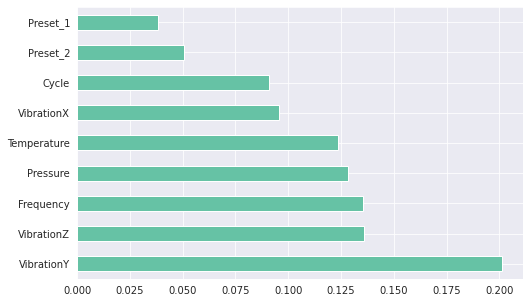

In [1450]:
#Tree Based Classifier
model = ExtraTreesClassifier()

#fit the model
model.fit(X,y)

#use inbuilt class feature_importances of tree based classifiers
print(model.feature_importances_)


#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(13).plot(kind='barh',figsize=(8,5))
plt.show()

<hr>

We may notice that the **Presets** are not too importants here, which we will still invastigate during this study.

We could drop the less important features(**Preset_1**, **Preset_2**) in case our model overfits to simplify the features.
<hr>

<hr>

**Correlation Matrix with Heatmap** — Correlation indicates how the features are related to each other or to the target variable.
The correlation may be positive (increase in one value of the feature increases the value of the target variable) or negative (increase in one value of the feature decreases the value of the target variable)
Heatmap makes it easy to classify the features are most relevant to the target variable, and we will plot the associated features of the heatmap using the seaborn library.
<hr>

[Text(0.5, 1.0, 'Pearson Correlation Matrix')]

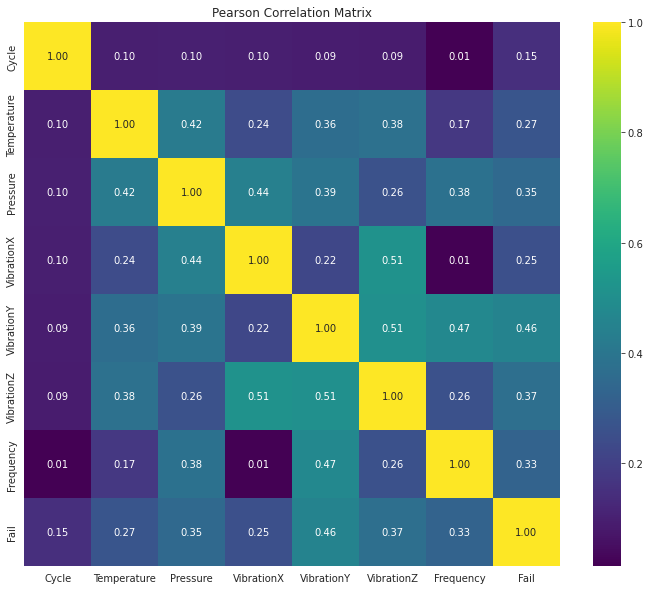

In [1451]:
#Correlation Matrix with Heatmap 
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cmap='viridis',fmt='.2f').set(title='Pearson Correlation Matrix')

<hr>

The correlation coefficient is defined in the -1 to 1 range. A value close to 0 means there is no correlation. Value of 1 suggests a perfect positive correlation (e.g. as the **VibrationY** increases, our number of fails increases too!). Value of -1 suggests perfect negative correlation (e.g. high number of bad reviews should correlate with lower prices).
<hr>

In [1452]:
#sort the values on the Fail row
df.corr().loc['Fail', :'Frequency'].sort_values()

Cycle          0.145643
VibrationX     0.252754
Temperature    0.272666
Frequency      0.325286
Pressure       0.345497
VibrationZ     0.367857
VibrationY     0.455435
Name: Fail, dtype: float64

<hr>

We can see that again the **VibrationY**, **VibrationZ**, **Pressure** and **Frequency** are the most important features in our dataset and will influence more on taking the machines to a fault condition.

On the first methodology the **Preset_1** and **Preset_2** influenced less than the other features and also from the **Cramer´s V Correlation Matrix** for categorical features, **Preset_1** and **Preset_2** are not highly correlated to the occurrences of Faults.So if our model overfits we can train without theses features to see if our performance increases.
<hr>

<hr>

- **Vibrations(X Y Z)** are highly correlated with each other as expected --> Vibration along one axis moves the other axis

- **Pressure** is highly correlated with **Temperature**  --> Pressure increases then Temperature increases (**Ideal Gas Law** from physics)

- **VibrationX** is highly correlated with **Temperature** --> Temperature increases then VibrationX increases

- **VibrationZ** is highly correlated with **Temperature** --> Temperature increases then VibrationZ increases

- **VibrationY** is highly correlated with **Pressure**   --> Pressure increases then VibrationY increases

- **VibrationY** is highly correlated with  **Frequency** --> Frequency increases then VibrationY increases

- **Fail** is highly correlated with **VibrationY**

**The most important insight here is that the fail is highly correlated with the VibrationY, so VibrationY tends to influence more in the models and take the machines to a Fault condition**.

<hr>

## 4. Data Visualization

<hr>
Let´s first have a look at the outliers, and understand if they are involved in the fail ocurrences.
<hr>


[Text(0.5, 1.0, 'Outliers Investigation'),
 Text(0.5, 0, 'Features'),
 Text(0, 0.5, 'Values')]

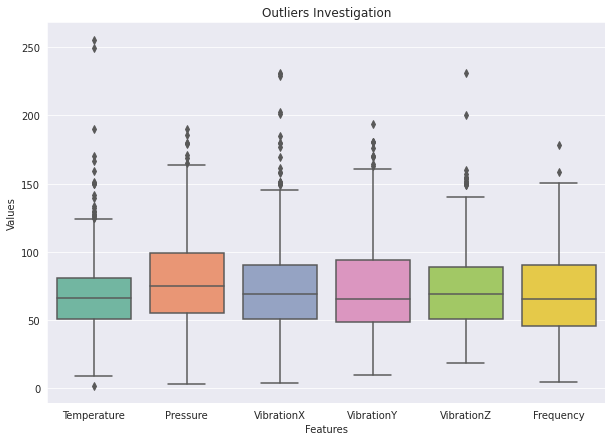

In [1453]:
#Setting the style of the plot
sns.set_style('darkgrid')
sns.set_palette('Set2')


#Only the numerical features are involved in this investigation
plt.figure(figsize = (10,7))
numerical_features = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
sns.boxplot(data = data[numerical_features]).set(title='Outliers Investigation',
                                                 xlabel='Features',
                                                 ylabel='Values')

<hr>

From Statistics we can count the total **upper** and **lower** outliers and the ones involved in the fault ocurrences:
<hr>

In [1460]:
# outliers subset
outl = data[numerical_features].copy()

# 0.25 and 0.75 quartiles
q1 = outl.quantile(0.25)
q3 = outl.quantile(0.75)

# interquartile range
iqr = q3 - q1

#upper and lower outliers borders
upper_outlier = q3 + (1.5 * iqr)
lower_outlier = q1 - (1.5 * iqr)


#Total number of outliers

total_outliers = ((outl < lower_outlier) |  (outl > (upper_outlier))).sum()

print('Total Outliers:\n\n', total_outliers)

print('\n-----------------------------------------------------------------------\n')

#upper and lower outliers involoved in the fault ocurrences
for f in numerical_features:
    
    # Sum of upper outliers involved and the porcentage of the total
    upper_outl_involved = np.sum(df[target][outl[f] > upper_outlier[f]])
    upper_porcentage_involved = (upper_outl_involved/total_outliers[f])*100
    print(f"{f}_upper_involved {upper_outl_involved} --> {upper_porcentage_involved}% of the total outliers")
    
    
    # Sum of lower outliers involved and the porcentage of the total
    lower_outl_involved = np.sum(df[target][outl[f] < lower_outlier[f]])
    lower_porcentage_involved = (lower_outl_involved/total_outliers[f])*100
    print(f"{f}_lower_involved: {lower_outl_involved} --> {lower_porcentage_involved} % of the total outliers\n")
    



Total Outliers:

 Temperature    22
Pressure        8
VibrationX     20
VibrationY     10
VibrationZ     14
Frequency       2
dtype: int64

-----------------------------------------------------------------------

Temperature_upper_involved 5 --> 22.727272727272727% of the total outliers
Temperature_lower_involved: 0 --> 0.0 % of the total outliers

Pressure_upper_involved 5 --> 62.5% of the total outliers
Pressure_lower_involved: 0 --> 0.0 % of the total outliers

VibrationX_upper_involved 5 --> 25.0% of the total outliers
VibrationX_lower_involved: 0 --> 0.0 % of the total outliers

VibrationY_upper_involved 6 --> 60.0% of the total outliers
VibrationY_lower_involved: 0 --> 0.0 % of the total outliers

VibrationZ_upper_involved 8 --> 57.14285714285714% of the total outliers
VibrationZ_lower_involved: 0 --> 0.0 % of the total outliers

Frequency_upper_involved 1 --> 50.0% of the total outliers
Frequency_lower_involved: 0 --> 0.0 % of the total outliers



<hr>

**So we can extract that the majority of the upper outliers are involved in the fault ocurrences**.

Therefore we are going to conduct our study **including the outliers of Temperature, Pressure, VibrationX, VibrationY, VibrationZ and Frequency** as they are relevant.

Having the option to train our data dropping **Preset_1** and **Preset_2**  from the dataset to simplify our model and reduce the chances to occur an overfiting.
<hr>

<hr>

## Fail Occurrences
Now we can study how imbalanced is our dataset. **We already expect an imbalanced dataset as engineering machines are project to be robust and last**.

So the occurrences of True labels will be the minority.But no problem, that is the natural distribution of this business problem.
<hr>

In [1461]:
#Extract the number of fault occurrences

true_occurrences = data['Fail'][data['Fail']==True].value_counts()
false_occurrences = data['Fail'][data['Fail']==False].value_counts()

print(f"False occurrences:{false_occurrences.values}\nTrue occurrences:{true_occurrences.values}")

#Porcentage of the total occurrences
false_occurrences_percentage = (false_occurrences/len(data))*100
true_occurrences_percentage = (true_occurrences/len(data))*100

print('\n----------------------------\n')
print(f"Didn´t Fail occurrences porcentage: {false_occurrences_percentage.values}%\nFail occurrences porcentage: {true_occurrences_percentage.values}%")

False occurrences:[734]
True occurrences:[66]

----------------------------

Didn´t Fail occurrences porcentage: [91.75]%
Fail occurrences porcentage: [8.25]%


<hr>

So the **Fail** occurrences are less than 10%. Also we can investigate methods to oversampling the minority class or just mantain the natural distributuion of the problem 
<hr>

[Text(0.5, 1.0, 'Data Distribution'),
 Text(0.5, 0, 'Fail'),
 Text(0, 0.5, 'Values')]

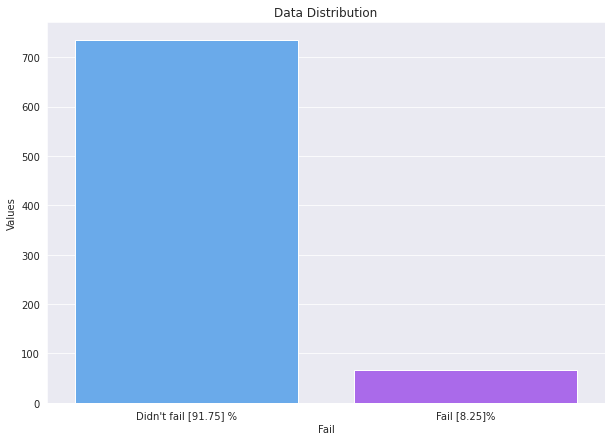

In [1462]:
#Plot the bar plot to visualize the distribution
plt.figure(figsize = (10,7))
sns.barplot(x = [f'Didn\'t fail {false_occurrences_percentage.values} %',f'Fail {true_occurrences_percentage.values}%'],
            y = list(data.Fail.value_counts()), palette='cool').set(title='Data Distribution',
                                                                    xlabel='Fail',
                                                                    ylabel='Values')


<hr>

- So we have 800 cycles in which 66(8.25%) fails and 734(91.75%) Don´t.

<hr>


<hr>

## Visualizing
Considering that we have the cycles we can visualize the occurrences of faults in time

We can take advantage of the library *plotly* to have an interactive plot
<hr>


In [1463]:
import plotly.graph_objects as go
import plotly.io as pio

#Creating figure and scatter plot
pio.renderers.default = "iframe" 

fig = go.Figure()
fig.add_trace(go.Scatter(x = data.Cycle,
                         y = data.Fail,
                         mode = 'lines',
                         name = 'Test'))

<hr>

From the interactive plot we can notice that the failures come together and **in some blocks recover then fails again**

So if the model keeps predicting **Fail** between very near faults its still good
<hr>

<hr>

## Counting the Duration of Cycles

we will get the **start**  and the **end** of each fail and calculate the **duration**

<hr>

In [1464]:
#indixes of each fail
fail_indixes = data['Cycle'][data['Fail']==True].to_list()


#starting the variables
hold = 12
duration = 0
duration_list = []
start_fail = [12]

#iterate to find 
for i in fail_indixes[1:]:
    if i-hold == 1:
        duration += 1
        
    else:
        duration_list.append(duration+1)
        duration = 0
        start_fail.append(i)
    hold = i
    
#get the value left        
duration_list.append(duration+1) 

#list comprehension to calculate the duration
ending = [x + y-1 for x, y in zip(start_fail, duration_list)]

countfails = pd.DataFrame({
    'Starting cycle': start_fail,
    'Ending cycle': ending,
    'Duration[Cycles]': duration_list
})

countfails

Starting cycle  Ending cycle  Duration[Cycles]
0              12            12                 1
1             157           159                 3
2             163           165                 3
3             263           265                 3
4             270           271                 2
5             415           432                18
6             538           546                 9
7             550           554                 5
8             700           713                14
9             793           800                 8

<hr>

**So we can see that some faults occur very close of each other, so probably the machine recovered and failed again in a short period of time**
<hr>

<hr>

## Mean Time Between Failures

It is a metric very used in Predictive Maintenance problems, and as the name suggests this is the time the machine is expected to work smoothly between failures

**MTBF = total working time / number of faults occurred**

Here we are going to group the near faults, so considering 7 as seen from the graphic

In [1465]:
#the near faults were considered as one, so we get 7
fail_groups = 7
print(false_occurrences/fail_groups)


False    104.857143
Name: Fail, dtype: float64


<hr>

**So after 104 cycles from a fault we can expect another fault to come and mobilize the maintenance team**
<hr>

<hr>

## Mean Time To Repair

Another very used metric in Predic Maintenance  is the Mean Time To Repair. With this we can have an idea of the time to repair a machine.

**MTTR = sum of repair duration/number of interventions performed**
<hr>

In [1466]:
#MTTR Formula
print((len(data)-false_occurrences)/fail_groups)

False    9.428571
Name: Fail, dtype: float64


<hr>

**So we can expect a time to repair about 10 cycles or a litle bit more**
<hr>

<hr>

## Equipment failures by Setups

**We already know from the first steps that the features Preset_1 and Preset_2 do not have too much influence in the fault occurrences** from the **Correlation Matrix** and **Feature Importance** steps. Although they don´t influence much in the occurrence of faults we are going to carry a study about the combinations that appear in the faults.  
<hr>

In [1467]:
#Back to int values to further apply the Target Encoding
data['Preset_1'] = data.Preset_1.astype(int)
data['Preset_2'] = data.Preset_2.astype(int)

Text(0.5, 1.0, 'Preset_1 v/s Count\n')

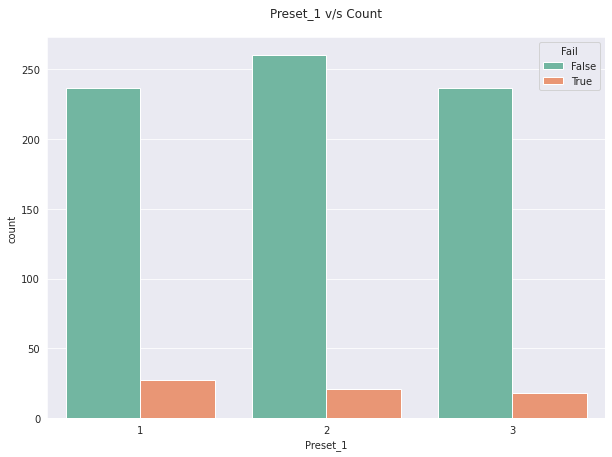

In [1468]:
#Preset 1 fault occurrences
plt.figure(figsize=(10,7))
sns.countplot(data= data, x='Preset_1',hue='Fail')
plt.title('Preset_1 v/s Count\n')


Text(0.5, 1.0, 'Preset_2 v/s Count\n')

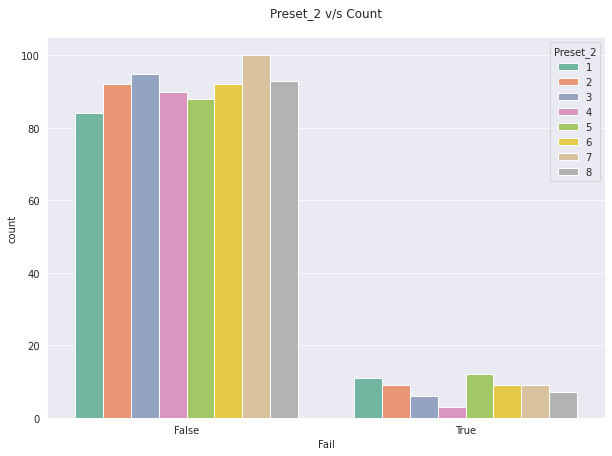

In [1469]:
#Preset 2 fault occurrences
plt.figure(figsize=(10,7))
sns.countplot(data= data, x='Fail',hue='Preset_2')
plt.title('Preset_2 v/s Count\n')

<Figure size 720x504 with 0 Axes>

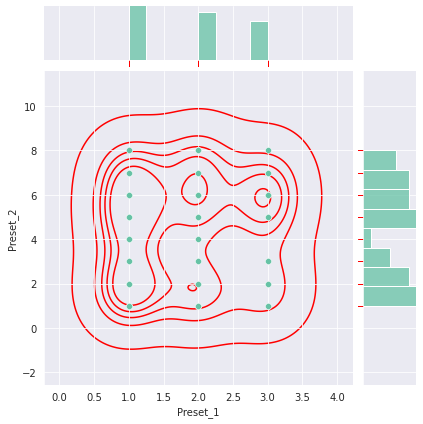

In [1470]:
#df['Fail'] == True - fault occurrences
df_fault = data[data['Fail'] == True ][['Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']] 

plt.figure(figsize=(10,7))
g = sns.jointplot(data=df_fault,
              x='Preset_1',
              y='Preset_2',
              )
g.plot_joint(sns.kdeplot, color="r",zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-.1, clip_on=False)

<hr>

From the visualization we can see that the combinations with **Preset_1 = 1** and **Preset_2 = 1 e 5** appear the most in the occurrences of faults
<hr>

## 5. Data Pre-processing

The goal here is to transform the data into a form that is suitable for your model. There are several things you want to do when handling (think CSV,Excel) structured data:

- Handle missing data
- Remove unnecessary columns
- Transform any categorical features to numbers
- Scale numerical features

<hr>

In [1471]:
#Listing our collumn names
data.columns

Index(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail'],
      dtype='object')

<hr>

### Label Encoder
In our target collumn whe have words (True and false), so we need **Label encoder** to convert to numbers (0 and 1) 

<hr>


In [1472]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

data[target]

0      False
1      False
2      False
3      False
4      False
       ...  
795     True
796     True
797     True
798     True
799     True
Name: Fail, Length: 800, dtype: bool

In [1473]:
#Label encoder instance and transformation of target collumn
le = LabelEncoder()
data['Fail'] = le.fit_transform(data.Fail)

In [1474]:
data.head()

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
0      1         3         6    44.235186   47.657254   46.441769   64.820327   
1      2         2         4    60.807234   63.172076   62.005951   80.714431   
2      3         2         1    79.027536   83.032190   82.642110   98.254386   
3      4         2         3    79.716242  100.508634  122.362321  121.363429   
4      5         2         5    39.989054   51.764833   42.514302   61.037910   

   VibrationZ  Frequency  Fail  
0   66.454520  44.483250     0  
1   81.246405  60.228715     0  
2   98.785196  80.993479     0  
3  118.652538  80.315567     0  
4   50.716469  64.245166     0

<hr>

### Mean Encoder/Target Encoder
If we decide to include in the training the **Presets** we will perform a *mean encoder* on these collumns

From a mathematical point of view, mean encoding represents a probability of your target variable, conditional on each value of the feature. In a way, it embodies the target variable in its encoded value.
<hr>

In [1475]:
# doing the mean encoder
data["Preset_1"] = data.groupby("Preset_1")["Fail"].transform("mean")
data["Preset_2"] = data.groupby("Preset_2")["Fail"].transform("mean")

In [1476]:
data.head()

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  VibrationY  \
0      1  0.070588  0.089109    44.235186   47.657254   46.441769   64.820327   
1      2  0.074733  0.032258    60.807234   63.172076   62.005951   80.714431   
2      3  0.074733  0.115789    79.027536   83.032190   82.642110   98.254386   
3      4  0.074733  0.059406    79.716242  100.508634  122.362321  121.363429   
4      5  0.074733  0.120000    39.989054   51.764833   42.514302   61.037910   

   VibrationZ  Frequency  Fail  
0   66.454520  44.483250     0  
1   81.246405  60.228715     0  
2   98.785196  80.993479     0  
3  118.652538  80.315567     0  
4   50.716469  64.245166     0

<hr>

### Gather columns
Using all the features provided
<hr>

In [1477]:
#Selection of the features used
features = ['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
category_cols = ['Preset_1','Preset_2']
#['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']

#independent columns
X = data.loc[:,features]
#target column 
y = data.loc[:,target]    



<hr>

### Splitting Data

We are going to use the train test split with test size of 40% of the total dataset

Here we need to set **shuffle to False** since we are working with a time series

<hr>

In [1478]:
from sklearn.model_selection import train_test_split

# Import train_test_split function
# 60% training and 40% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=0,
                                                    shuffle=False) 
X_train

Cycle  Preset_1  Preset_2  Temperature    Pressure  VibrationX  \
0        1  0.070588  0.089109    44.235186   47.657254   46.441769   
1        2  0.074733  0.032258    60.807234   63.172076   62.005951   
2        3  0.074733  0.115789    79.027536   83.032190   82.642110   
3        4  0.074733  0.059406    79.716242  100.508634  122.362321   
4        5  0.074733  0.120000    39.989054   51.764833   42.514302   
..     ...       ...       ...          ...         ...         ...   
475    476  0.102273  0.089109    63.889772   75.337097   82.952755   
476    477  0.074733  0.070000    65.561130  136.592852   92.927337   
477    478  0.074733  0.089109    58.286151   60.322216   60.669999   
478    479  0.070588  0.070000    99.585316  124.564811   52.321959   
479    480  0.074733  0.032258    49.897503   56.419541   43.132203   

     VibrationY  VibrationZ   Frequency  
0     64.820327   66.454520   44.483250  
1     80.714431   81.246405   60.228715  
2     98.254386   98.785196   80.993479  
3    121.363429  118.652538   80.315567  
4     61.037910   50.716469   64.245166  
..          ...         ...         ...  
475   53.909298   96.398103  105.214550  
476   53.344402   96.085591  134.384686  
477  104.863646  104.328180  103.991047  
478  104.296327   52.783798   70.911968  
479   41.689672   37.363185   85.238530  

[480 rows x 9 columns]

<hr>

### Normalization

To avoid data leak we are going to apply a **MinMax Scaler** since this takes into account the outlliers that we saw are important to our model to classify well the Fail occurrences 
<hr>

In [1479]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# build the scaler model
MinMaxScaler = MinMaxScaler()


# fit using the train set

X_train[features] = MinMaxScaler.fit_transform(X_train[features])

X_test[features] = MinMaxScaler.fit_transform(X_test[features])

X_train


Cycle  Preset_1  Preset_2  Temperature  Pressure  VibrationX  \
0    0.000000  0.000000  0.647932     0.166244  0.236854    0.180360   
1    0.002088  0.130817  0.000000     0.231612  0.320037    0.249534   
2    0.004175  0.130817  0.952012     0.303482  0.426517    0.341250   
3    0.006263  0.130817  0.309406     0.306198  0.520216    0.517784   
4    0.008351  0.130817  1.000000     0.149495  0.258877    0.162905   
..        ...       ...       ...          ...       ...         ...   
475  0.991649  1.000000  0.647932     0.243771  0.385259    0.342631   
476  0.993737  0.130817  0.430147     0.250364  0.713681    0.386962   
477  0.995825  0.130817  0.647932     0.221667  0.304757    0.243596   
478  0.997912  0.000000  0.430147     0.384571  0.649193    0.206494   
479  1.000000  0.130817  0.000000     0.188579  0.283833    0.165651   

     VibrationY  VibrationZ  Frequency  
0      0.298414    0.224683   0.230649  
1      0.385024    0.294401   0.321316  
2      0.480604    0.377066   0.440886  
3      0.606530    0.470706   0.436983  
4      0.277803    0.150506   0.344444  
..          ...         ...        ...  
475    0.238957    0.365815   0.580359  
476    0.235879    0.364342   0.748329  
477    0.516619    0.403192   0.573313  
478    0.513528    0.160249   0.382834  
479    0.172370    0.087568   0.465331  

[480 rows x 9 columns]

<hr>

### SMOTE - Synthetic Minority Oversampling Technique

Smote is a oversampling method and was tested to **generate synthetic minority** class ocurrences, but with no sucess since the data is a a time series.

**Thus is better to mantain the natural distribution of our problem**
<hr>

In [1480]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

#cc = ClusterCentroids(random_state=0,sampling_strategy=0.9)
#smote = SMOTE(random_state=0,sampling_strategy=0.07)


#X_train, y_train= smote.fit_resample(X_train, y_train)


<hr>

## Machine Learning Models
**This is a Supervised Machine Learning problem**

We have the the challenge to classify **True or False**, so we are going to use **binary classifiers**.

I have picked some that are suitable for the problem.I tried to select models from different categories

- Logistic Regression
- Support Vector Machines - SVM
- Random Forest
- CatBoost
- XGBoost Classifier


We will compare these models using some metrics: 

- Accuracy
- Precision
- Recall
- Score F1
- Confusion matrix

These metrics are the most used in Machine Learning problems.In this specific problem we need to take care of the **False Negatives** because costs more money to not classify correctly an occurrence of Fault.

**So we will focus on the Recall and Score F1 since they take into account the influence of the recall and false negatives**

**Remembering that our minority class is the most important here**

<hr>

### 4. Fitting into Model

In [1481]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Support Vector Machines
from sklearn.svm import SVC

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGboost
import xgboost as xgb


# CatBoost
from catboost import CatBoostClassifier


# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [1482]:
models = {}

#Our Five models chosen
models['Logistic Regression'] = LogisticRegression(random_state = 0)

models['Support Vector Machines'] = SVC(random_state = 0)

models['Random Forest'] = RandomForestClassifier(random_state=0)

models['CatBoost'] = CatBoostClassifier(random_state=0, verbose=0)

models['XgBoost'] = xgb.XGBClassifier(random_state=0,
                                      objective= 'binary:logistic',
                                      use_label_encoder=False)



In [1483]:
accuracy, precision, recall, f1score, fn = {}, {}, {}, {}, {}

for key in models.keys():
    
    
    # fit the classifier model in the dictionary
    models[key].fit(X_train, y_train.values.ravel())

    
    # prediction 
    predictions = models[key].predict(X_test)

    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    print(key,'\n',classification_report(y_test, predictions),'\n\n\n')
    
    # calculate metrics
    accuracy[key] = accuracy_score( y_test, predictions)
    precision[key] = precision_score(y_test, predictions)
    recall[key] = recall_score( y_test, predictions)
    f1score[key] = f1_score( y_test, predictions)
    fn[key] = FN

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1-Score'] = f1score.values()
df_model['FN'] = fn.values()


df_model

Logistic Regression 
               precision    recall  f1-score   support

           0       0.93      0.98      0.96       284
           1       0.73      0.44      0.55        36

    accuracy                           0.92       320
   macro avg       0.83      0.71      0.75       320
weighted avg       0.91      0.92      0.91       320
 



Support Vector Machines 
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       284
           1       0.56      0.39      0.46        36

    accuracy                           0.90       320
   macro avg       0.74      0.68      0.70       320
weighted avg       0.88      0.90      0.89       320
 



Random Forest 
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       284
           1       0.54      0.92      0.68        36

    accuracy                           0.90       320
   macro avg       0.76      0.91      0.81       320
we

Accuracy  Precision    Recall  F1-Score  FN
Logistic Regression      0.918750   0.727273  0.444444  0.551724  20
Support Vector Machines  0.896875   0.560000  0.388889  0.459016  22
Random Forest            0.903125   0.540984  0.916667  0.680412   3
CatBoost                 0.906250   0.550000  0.916667  0.687500   3
XgBoost                  0.890625   0.507463  0.944444  0.660194   2

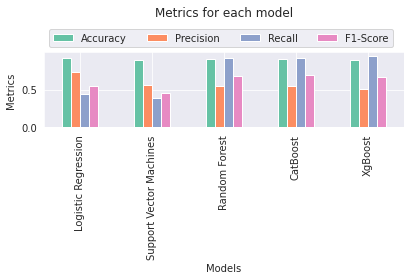

In [1484]:
#Visualize the metrics by model
ax  = df_model[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot.bar(rot=90)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.title('Metrics for each model\n\n')
plt.ylabel('Metrics ')
plt.xlabel('Models')

plt.tight_layout()

<hr>

From the analysis we will keep with the **Random Forest** model with the good **macro F1** and **Accuracy** and number of **False Negatives**

Next we will visualize the number of false negatives

<hr>

Text(0, 0.5, 'False Negatives')

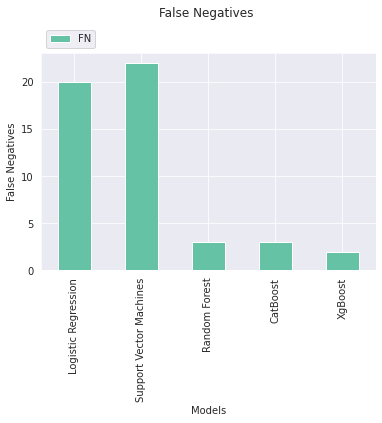

In [1485]:
#Visualizing the number of False Negatives
ax  = df_model[['FN']].plot.bar(rot=90)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
plt.title('False Negatives \n\n')
plt.xlabel('Models')
plt.ylabel('False Negatives')


<hr>

## Predict

Now we can make predictions with the chosen model
<hr>

In [1486]:
model = models['Random Forest']
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

<hr>

**Confusion Matrix** helps us to visualize model performance. It gives count of correctly classified points and misclassified points for each classes.
<hr>

<AxesSubplot:>

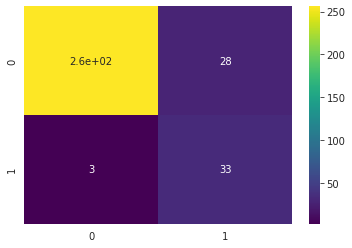

In [1487]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

### Interactive Plot


<hr>

In [1488]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(j)
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


In [1489]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))

<hr>

## Cross Validation and Random Forest Hyperparameter 

In the case of time series, the cross-validation is not trivial. We cannot choose random samples and assign them to either the test set or the train set because it makes no sense to use the values from the future to forecast values in the past. 

Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.

Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.
![title](img.png)
<hr>

## Random Forest

With the GridSearch we can look for the best combinations of parameters of the chosen model, dividing our Cross Validation with 5 splits

**In the GridSearch our scoring is f1_macro as we need to take care of the minority class**
<hr>

In [1490]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


folds = TimeSeriesSplit(n_splits=5)

# random forest model
r_forest_clf = RandomForestClassifier(random_state=21, 
                                      n_jobs=-1,
                                     warm_start=True)


# parameter to tune
# n_estimators: The function to measure the quality of a split. 
# max_depth: maximum depth of the tree

param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'n_estimators': [1,3,4,5,6,7,8,9,10,12,14,16,18,20,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45],
    'max_features': ['auto'],
    'bootstrap': [True],
    'criterion':['gini','entropy']
    }


# defining model to tune hyperparameter
r_forest_cv = GridSearchCV(estimator=r_forest_clf,
                        param_grid=param_grid,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

r_forest_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=21,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15],
                         'max_features': ['auto'],
                         'n_estimators': [1, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14,
                                          16, 18, 20, 25, 26, 27, 28, 29, 30,
                                          31, 32, 33, 34, 35, 36, 37, 38, 39,
                                          40, ...]},
             return_train_score=True, scoring='f1_macro')

In [1491]:
# to take a look of the best parameters chosen
r_forest_cv.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 37}

In [1492]:
#the instance of our best model from gridsearch
best_grid = r_forest_cv.best_estimator_

<hr>

## Classification Report
<hr>

In [1493]:
#our predicions
y_pred = best_grid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.92      0.95       284
           1       0.59      0.92      0.72        36

    accuracy                           0.92       320
   macro avg       0.79      0.92      0.83       320
weighted avg       0.94      0.92      0.93       320



<hr>

## Confusion Matrix
3 False negatives leads to a good **Recall**
<hr>

<AxesSubplot:>

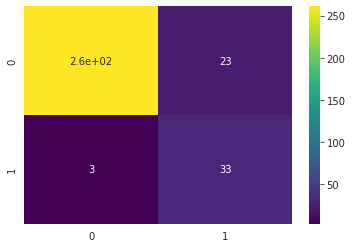

In [1494]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

## ROC Curve and Roc_Auc_Score
**ROC_auc_score = 0.92**

ROC Curves and ROC AUC can be **optimistic on severely imbalanced classification problems** with few samples of the minority class

<hr>

Random Forest: ROC_auc = 0.91784


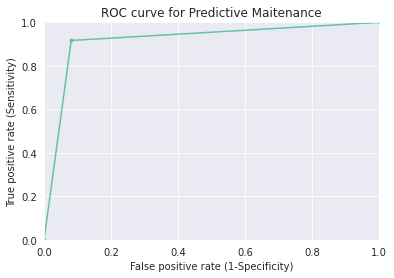

In [1495]:
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Predictive Maitenance')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)



from sklearn.metrics import average_precision_score


# summarize scores
roc_auc = roc_auc_score(y_test,y_pred)
print('Random Forest: ROC_auc = %.5f' % (roc_auc))


<hr>

## Precision Recall Curve
 The Precision-Recall Plot is more informative than the ROC Plot when evaluating binary classifiers on Imbalanced Datasets.
 
- ROC curves should be used when there are roughly equal numbers of observations for each class.
- Precision-Recall curves should be used when there is a moderate to large class imbalance.

The reason for this recommendation is that ROC curves present an optimistic picture of the model on datasets with a class imbalance.

<hr>

Random Forest: f1=0.71739 
               AUC=0.75766


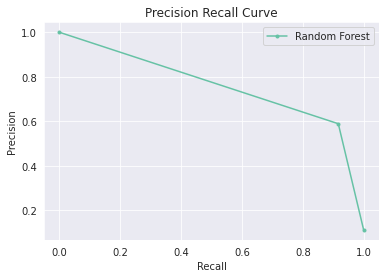

In [1496]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# calculate F1 score
f1 = f1_score(y_test, y_pred)

# calculate precision-recall AUC
auc_PRcurve = auc(recall, precision)

# summarize scores
print('Random Forest: f1=%.5f \n               AUC=%.5f' % (f1, auc_PRcurve))


plt.plot(recall, precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

<hr>

## Interactive Visualization
<hr>

In [1497]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(j)
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))

<hr>

##  Visualization of one Decision Tree inside our Random Forest :
<hr>

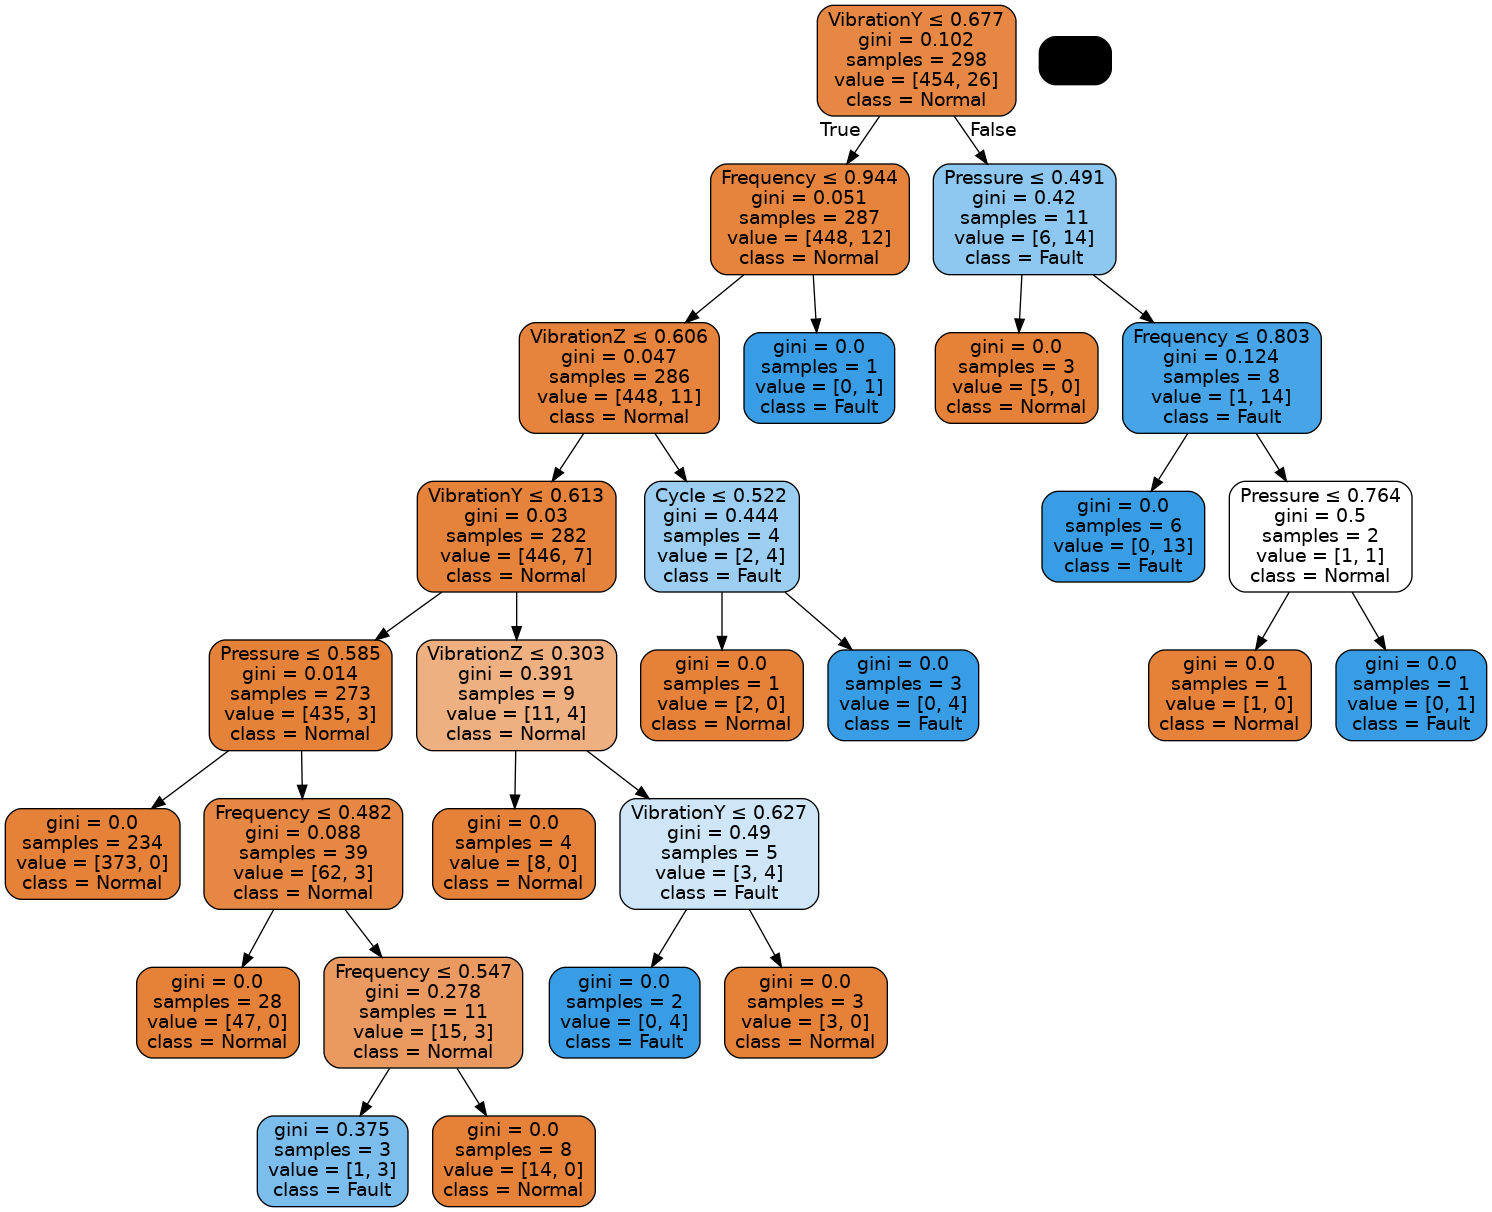

In [1498]:

from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

estimator = best_grid.estimators_[9]
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features  ,class_names=['Normal','Fault'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('SHAPE.png')
Image(graph.create_png())

<hr>

# ML EXPLAINABILITY:
- ## SHAP (SHapley Additive exPlanations)

Time to explain how the features influences the decisions inside our model using SHAP
<hr>

<hr>

 - ## Global Predictions Features Summary:
 
<hr>

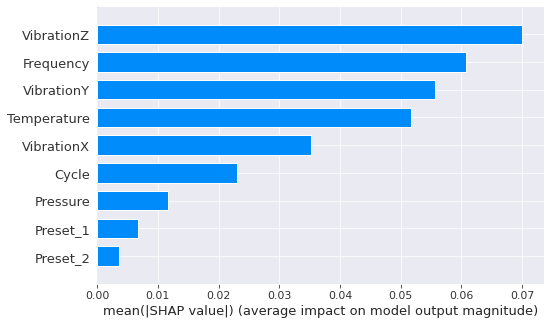

In [1513]:
import shap
explainer = shap.TreeExplainer(best_grid)
shap_values = explainer.shap_values(X_test,check_additivity=False)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")


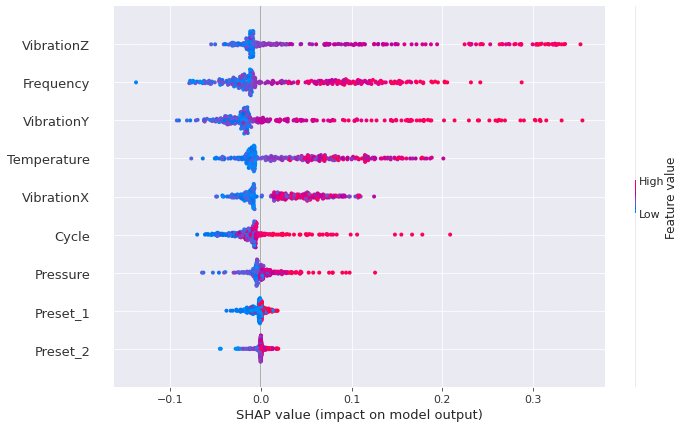

In [1514]:
#Shap value for Model Explaination
shap.summary_plot(shap_values[1], X_test, plot_size=(11,7))

<hr>

As we have already stated on the first steps that the **higher values** of **Vibrations on axis Z and Y and also the frequency** have a big influence on the decisions taken in our model

**Also we see that the presets Don´t have a big impact on the predictions**
<hr>

<hr>

 - ## Local Predictions:
 
<hr>

In [1507]:
#Our function tho generate the shap graph
def machine_analysis(model, cycle):
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(cycle)
  shap.initjs()
  return shap.force_plot(explainer.expected_value[1], shap_values[1], cycle)

In [1516]:
cycle = X_test.iloc[318,:].astype(float)
cycle_target = y_test.iloc[318]
print(' Target : ',int(cycle_target))

machine_analysis(best_grid, cycle)

 Target :  1


<hr>

**As we see again Vibration in Y and Z Pressure and Frequency are very important**.
<hr>

In [1527]:
shap_values = explainer.shap_values(X_train.iloc[200:320],check_additivity=False)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:320])

<hr>

## Conclusion

<hr>

We concluded our analysis of the data and with a simple random forest with the gridsearch model to predict failure. We also got a lot insights from the data and used on our favor to get the best results

**The model has an accuracy of 0.92 and a ROC_auc_score of 0.92 and Macro F1-Score of 0.83 which is satisfactory .**

For further studies we can:
- Deploy the model with Flask which is simple and Pythonic
- look for methods to artificially generate more data of the minority class for time series datasets as the SMOTE in not a good approach
- Implement LSTM which could be good for this time series data or a simpler Artificial Neuralk Network

Also considering the business problem and features involved such as **Pressure, Temperature, Frequency and Vibrations**, we can guess that the machine in question is a Flux Machine such as a **pump or a compressor** 

<hr>

# Extra Experiments
<hr>

<hr>

## Cross Validation and Catboost Hyperparameter 

<hr>

In [776]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

folds = TimeSeriesSplit(n_splits=5)

# CAtBoost model
catboost_clf =  CatBoostClassifier(random_state=0,
                                   verbose=0)


params = {'depth':[6,4,5,7,8,9,10],
          'iterations':[15,20,25,28,29,30,31,32,35,40,45,50],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3,0.4,0.5]} 
          


 

In [142]:
# defining model to tune hyperparameter
catboost_cv = GridSearchCV(estimator = catboost_clf,
                        param_grid=params,
                        cv=folds,
                        scoring='f1_macro',
                        n_jobs=-1,
                        return_train_score=True)

catboost_cv.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostClassifier object at 0x7f3525198250>,
             n_jobs=-1,
             param_grid={'depth': [6, 4, 5, 7, 8, 9, 10],
                         'iterations': [15, 20, 25, 28, 29, 30, 31, 32, 35, 40,
                                        45, 50],
                         'learning_rate': [0.03, 0.001, 0.01, 0.1, 0.2, 0.3,
                                           0.4, 0.5]},
             return_train_score=True, scoring='f1_macro')

In [145]:
# to take a look of the best parameters chosen
catboost_cv.best_params_

{'depth': 8, 'iterations': 29, 'learning_rate': 0.4}

In [146]:
#the instance of our best model from gridsearch
best_grid = catboost_cv.best_estimator_

<hr>

## Classification Report
<hr>

In [147]:
#our predicions
y_pred = best_grid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.93      0.95       284
           1       0.60      0.81      0.69        36

    accuracy                           0.92       320
   macro avg       0.79      0.87      0.82       320
weighted avg       0.93      0.92      0.92       320



<hr>

## Confusion Matrix

<hr>

<AxesSubplot:>

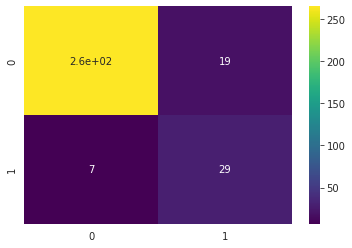

In [148]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

## ROC Curve
<hr>

Random Forest: ROC_auc = 0.86933


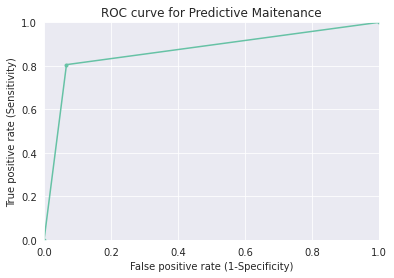

In [149]:
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Predictive Maitenance')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)



from sklearn.metrics import average_precision_score


# summarize scores
roc_auc = roc_auc_score(y_test,y_pred)
print('Random Forest: ROC_auc = %.5f' % (roc_auc))


<hr>

## Precision-Recall Curve
<hr>

Catboost: f1=0.69048 
              auc=0.71580


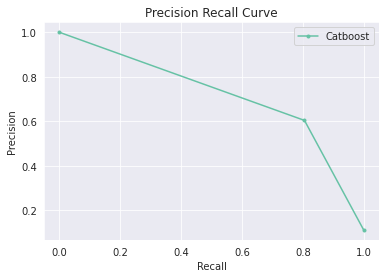

In [150]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# calculate F1 score
f1 = f1_score(y_test, y_pred)

# calculate precision-recall AUC
auc_PRcurve = auc(recall, precision)

# summarize scores
print('Catboost: f1=%.5f \n              auc=%.5f' % (f1, auc_PRcurve))


plt.plot(recall, precision, marker='.', label='Catboost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

<hr>

## Interactive Visualization
<hr>

In [151]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(j)
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_pred,
                    mode='markers',
                    name='Pred'))

<hr>

# Deep Learning Approach with Keras Framework

Cross-validation in Deep Learning (DL) might be a little tricky because most of the CV techniques require training the model at least a couple of times. 

In deep learning, we would normally tempt to avoid CV because of the cost associated with training k different models. Instead of doing k-Fold or other CV techniques, you might use a random subset of your training data as a hold-out for validation purposes.

For example, Keras the deep learning library we use allows us to pass one of two parameters for the fit function that performs training.

- **validation_split**: percentage of the data that should be held out for validation
- **validation_data**: a tuple of (X, y) which should be used for validation. This parameter overrides the validation_split parameter which means we can use only one of these parameters at once.

The same approach is used in official tutorials of other DL frameworks such as PyTorch and MxNet. They also suggest splitting the dataset into three parts: training, validation, and testing.

- **Training** – a part of the dataset to train on
- **Validation** – a part of the dataset to validate on while training
- **Testing** – a part of the dataset for final validation of the model


<hr>

<hr>

### Gather columns
Using all the non categorical features provided in order to simplify our model, improve generalization in new unseen data and avoid overfitting.
<hr>

In [1570]:
#Selection of the features used
features = ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']
category_cols = ['Preset_1','Preset_2']
#['Cycle','Preset_1','Preset_2','Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency']

#independent columns
X = data.loc[:,features]
#target column 
y = data.loc[:,target]    



<hr>

### Splitting Data

We are going to use the train test split with test size of 20% of the total dataset

Here we need to set shuffle to False since we are working with a time series

<hr>

In [1572]:
from sklearn.model_selection import train_test_split

# Import train_test_split function
# 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0,
                                                    shuffle=False) 


<hr>

### Normalization

To avoid data leak we are going to apply a **MinMax Scaler** since this takes into account the outlliers that we saw are important to our model to classify well the Fail occurrences 
<hr>

In [1576]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# build the scaler model
MinMaxScaler = MinMaxScaler()


# fit using the train set

X_train[features] = MinMaxScaler.fit_transform(X_train[features])

X_test[features] = MinMaxScaler.fit_transform(X_test[features])



<hr>

## Keras Neural Network

Keras is the official high-level API for TensorFlow. In short, it allows us to build complex models using a friendly interface.
<hr>

In [1533]:
#Imports
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

BATCH_SIZE = 32

<hr>

- ### Defining the model
The sequential Class allows us to add various layers to your model, easily. Note that we specify the input_size in the first layer using the training data. We also do regularization using **Dropout** layers.

<hr>

In [1534]:
# define the keras model
model = Sequential()
model.add(Dense(64,
                input_dim=X_train.shape[1],
                activation='relu')
         )
model.add(Dropout(rate=0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(1, activation='sigmoid'))

<hr>

- ### Custom Metrics & Compilation of the model

The compile() method lets us specify the **optimizer** and the **error metric** (*Binary CrossEntropy*) we need to reduce.Also the metrics to rank the best models **Accuracy** and **F1_score**.

<hr>

In [1535]:
from keras import backend as K

# Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [1536]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',custom_f1])

<hr>

- ### Early Stopping

This callback function will stop the training when there is no improvement in the loss for defined patience consecutive epochs, which is a signal that our model is starting to overfit the train data.
<hr>

In [1537]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
early_stop = EarlyStopping(monitor = "val_loss",
                         patience = 10,
                         verbose = 1,
                         mode = "auto")

<hr>

- ### Training the model

We feed the training method with the training data and specify the following parameters:

- epochs - number of training cycles
- validation_split - use some percent of the data for measuring the error and not during training
- batch_size - the number of training examples that are fed at a time to our model
- callbacks - we use EarlyStopping to prevent our model from overfitting when the training and validation error start to diverge

<hr>

In [1538]:
# fit the keras model on the dataset
history = model.fit(X_train,
                    y_train,
                    epochs=1000,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=0)

Epoch 00120: early stopping


<hr>

- ### Visualization of Accuracy during training

<hr>

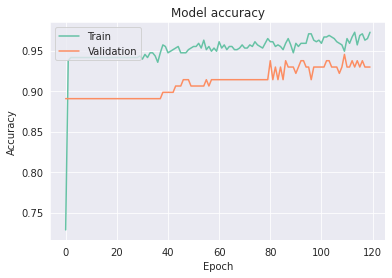

In [1539]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<hr>


- ### Visualization of F1 score during training

<hr>

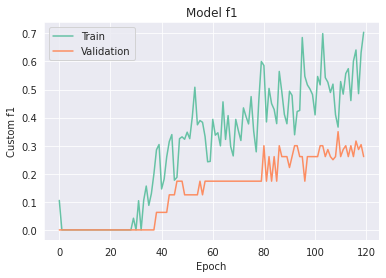

In [1540]:
plt.plot(history.history['custom_f1'])
plt.plot(history.history['val_custom_f1'])
plt.title('Model f1')
plt.ylabel('Custom f1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<hr>

- ### Visualization of Loss during training

<hr>

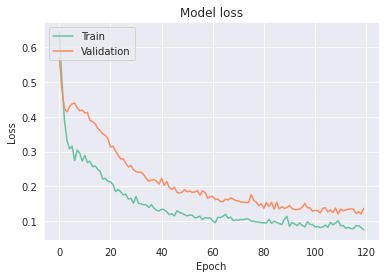

In [1541]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

<hr>

- ### Evaluation with Classification Report 

Now it is time to use the additional test data and test how good is our model.

Note that we don’t use that data during the training, only once at the end of the process.

<hr>

In [1659]:
#Round elements of the array to the nearest integer
y_pred = np.rint(model.predict(X_test))

# Model Accuracy, how often is the classifier correct?
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.95      0.97       138
           1       0.74      0.91      0.82        22

    accuracy                           0.94       160
   macro avg       0.86      0.93      0.89       160
weighted avg       0.95      0.94      0.95       160



<hr>

- ### Confusion Matrix

<hr>

<AxesSubplot:>

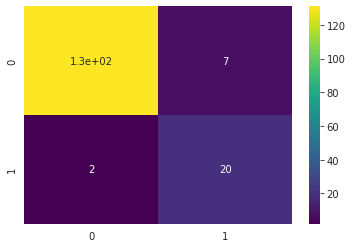

In [1660]:
#Confusion matrix
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,cmap='viridis')

<hr>

- ### Interactive Visualization on Testing Data

<hr>

In [1596]:
actual = []
predcition = []
for i,j in zip(y_test,y_pred):
  actual.append(i)
  predcition.append(int(j))
dic = {'Actual':actual,
       'Prediction':predcition
       }
result  = pd.DataFrame(dic)


In [1597]:


import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe" 
fig = go.Figure()

 
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=y_test,
                    mode='markers+lines',
                    name='Test'))
fig.add_trace(go.Scatter(x=np.arange(0,len(y_test)), y=result['Prediction'],
                    mode='markers',
                    name='Pred'))

<hr>

## Defining Column Transformers

We enumerate all columns that need feature scaling on deploying. 
<hr>

In [1666]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
import joblib

transformer = make_column_transformer(
    (MinMaxScaler(), ['Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency'])
)

transformer.fit(X)
X[415:]

Temperature    Pressure  VibrationX  VibrationY  VibrationZ   Frequency
415    76.867426   50.822002  101.404636  100.327893  200.242674   50.415427
416    80.356903   73.118922  149.395736   75.027844  149.767904   48.923777
417    81.546261   80.413020   88.977458  111.031598  129.166580  110.712088
418    79.538015   99.512446  119.314389  137.754901  149.189787  109.731930
419    79.546347   91.127475   79.626131  131.729198  110.214551  110.229684
..           ...         ...         ...         ...         ...         ...
795    50.469522   98.235421  151.585252   99.341380  148.838481   49.841400
796    49.985270  160.433640  110.953010  160.777175  109.917566  110.919290
797    79.777294  110.535405   61.334995  149.577811  129.463843   70.853353
798    79.360314  159.985443   61.762879  169.773831  130.213426   80.113540
799    80.854011  110.543701  121.032227  131.719473   90.331155   71.261717

[385 rows x 6 columns]

<hr>

## Saving Model and Tranform for deploy
Now that we have a trained model, we need to store it and be able to reuse it later.

- The recommended approach of storing scikit-learn models and transforms is to use **joblib**.

- Saving the model architecture and weights of a **Keras** model is done with the save() method.

<hr>

In [1604]:
#Save the transformer using the dump method
joblib.dump(transformer, "minmax_scaler.joblib")
#Save the model using the save method from Keras in h5 format
model.save("Shape_prediction_model.h5")

<hr>

## Deploy of the Keras Neural Network on Web

A web application is developed using HTML and Flask web framework which is capable of predicting single point input and multiple inputs.

A REST API allows you to use your model to make predictions for different clients. Almost any device can speak REST - Android, iOS, Web browsers, and many others.

We are going to use **Flask** that allows us to  easily build a REST API as it´s fully supported by Python .

[Keras Model Deployed - Web App ](http://172.28.255.122:5000/)
<hr>